# System Dynamics: Ebola outbreak in Nigeria 2014

Ordinary differential equations (ODEs) are an invaluable tool for modelling and analysis of complex systems. 
In system dynamics terminology ODEs model stocks and flows. 
Unfortunately, their handling is not trivial and outside of academia it is not commonly used. 
However, with just a few lines of code it is possible to plot the functions which allow straightforward interpretation of the interdependencies.
In order to make this work, the initial conditions and the coefficients of the equations must be known.


<a href="http://dx.doi.org/10.1016/j.epidem.2015.03.001">Althaus et al. (2015)</a> estimated coefficients for the following set of differential equations modelling the Ebola outbreak in Nigeria 2014.

\begin{align}
\frac{\partial S}{\partial t} & = -\beta(t) S I \\
\frac{\partial E}{\partial t} & = \beta(t) S I - \sigma E \\
\frac{\partial I}{\partial t} & = \sigma E - \gamma I \\
\frac{\partial R}{\partial t} & = (1-f) \gamma I \\
\frac{\partial D}{\partial t} & = f \gamma I \\
\end{align}

$S$ = susceptible, $E$ = exposed, $I$ = infectious, $R$ = recovered, $D$ = dead

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1755436515000341-gr1.jpg" />

These are the coefficients:

\begin{align}
\beta(t) & = \beta_{0} e^{-k(t - \tau)} \\
\beta_0 & = 1.22 * 10^{-6} \\
\sigma & = 0.11 \\
\gamma & = 0.13 \\
f & = 0.39 \\
\tau & = 3 \\
k & = 0.19
\end{align}

$\beta$: transmission rate with infected individuals, 
$\gamma$: ‘‘recovery or death’’ rate, 
$\sigma$: incubation rate, 
$f$: case fatality rate, 
$\tau$: Time (in days) at which control measures were introduced, 
k: transmission reduction rate

All initial stocks at $t=0$ are empty except the initial number of susceptible individuals $S(0)$ is 10<sup>6</sup> and the initial number of infectious individuals $I(0)$ is 1.
The development is computed over 100 days ($t$). 
Surprisingly, individuals who recovered from Ebola develop immunity. 

The transmission rate ($\beta$) is expected only to be constant until the implementation of control interventions at t=$\tau$ and exponentially decaying afterwards. 
Comparing the proposed model with one having a constant transmission rate points out the tremendous importance of rapid implementation of control measures in order to reduce the spread of the disease.

Reference: <br />
Althaus C.L., Low N, Musa E.O., Shuaib F., Gsteiger S. (2015). <a href="http://dx.doi.org/10.1016/j.epidem.2015.03.001">Ebola virus disease outbreak in Nigeria: transmission dynamics and rapid control</a>. Epidemics 11(0): 80–84

In [2]:
library(deSolve) # ode
library(ggplot2)
library(dplyr) # rename, %>% 
library(tidyr) # gather
options(repr.plot.width=7, repr.plot.height=4) # just for Jupytr

## 1. Constant transmission rate: $\beta_0$

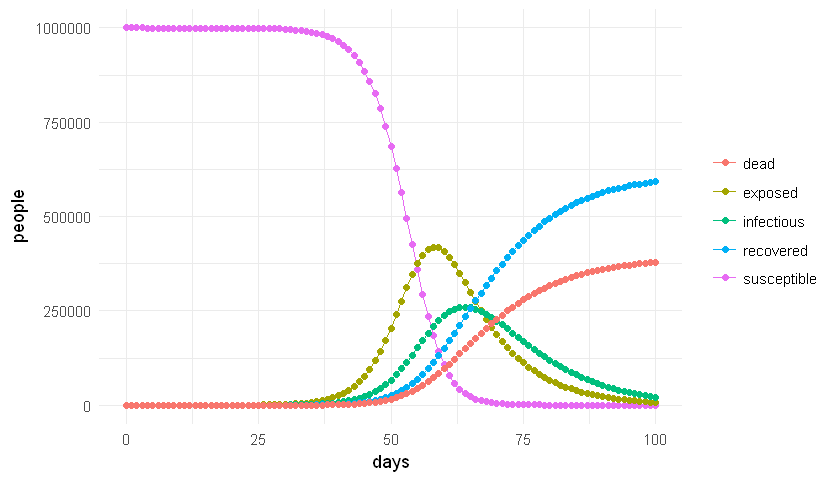

In [3]:
model <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS = -b*S*I -a*S*D
    dE = b*S*I +a*S*D -s*E
    dI = s*E - g*I
    dR = (1-f)*g*I
    dD = f*g*I
    return(list(c(dS, dE, dI, dR, dD)))
  })
}

table <- ode(func = model,
           y = c(S=1000000, E=0, I=1, R=0, D=0), # stocks t=0
           parms = c(a=0, b=1.22e-06, s=1/9.31, g=1/7.41, f=0.39),
           times = seq(0, 100, by = 1)) %>% as.data.frame

table %>% 
  rename(susceptible=S, exposed=E, infectious=I, recovered=R, dead=D) %>% # rename(newname = oldname)
  gather(key="group", value="people", -time) %>% # long-format
  ggplot(aes(x=time, y=people, col=group)) +
    geom_line() +
    geom_point() +
    theme_minimal() +
    xlab("days") +
    theme(legend.title=element_blank())

## 2. Time-dependent transmission rate: $\beta(t) = \beta_{0} e^{-k(t - \tau)}$

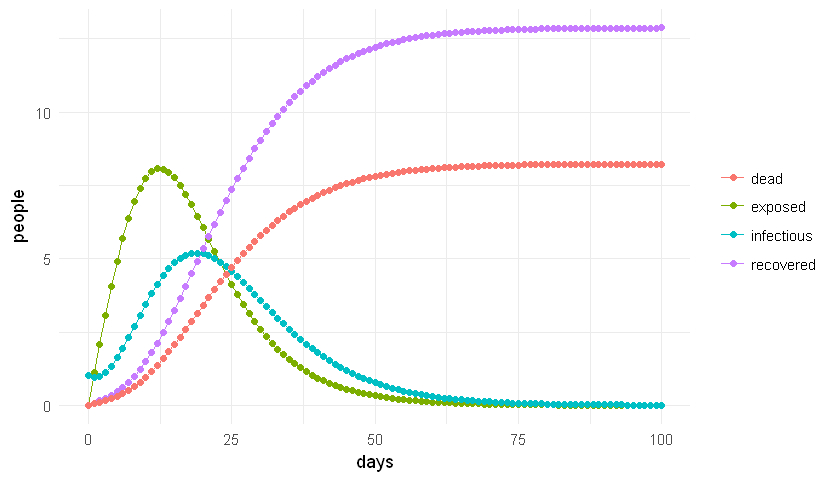

In [4]:
beta <- function(t, b, tau, k){
  ifelse(t < tau, b, b*exp(-k*(t-tau)))
}

# beta(t=c(0:100), b=1.22e-06, tau=3, k=0.19) %>% plot(type="l")

model <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS = -beta(time, b, tau, k)*S*I -a*S*D
    dE = beta(time, b, tau, k)*S*I +a*S*D -s*E
    dI = s*E - g*I
    dR = (1-f)*g*I
    dD = f*g*I
    return(list(c(dS, dE, dI, dR, dD)))
  })
}

table <- ode(func = model,
             y = c(S=1000000, E=0, I=1, R=0, D=0),
             parms = c(a=0, b=1.22e-06, s=1/9.31, g=1/7.41, f=0.39, tau=3, k=0.19),
             times = seq(0, 100, by = 1)) %>% as.data.frame

table %>% 
  rename(susceptible=S, exposed=E, infectious=I, recovered=R, dead=D) %>%
  select(-susceptible) %>%
  gather(key="group", value="people", -time) %>%
  ggplot(aes(x=time, y=people, col=group)) +
    geom_line() +
    geom_point() +
    theme_minimal() +
    xlab("days") +
    theme(legend.title=element_blank())